# 04 — Radar Profiles: Bruno Fernandes vs Casemiro

This notebook builds radar charts comparing Bruno Fernandes and Casemiro
using per-90 metrics from matches where both start together for
Manchester United.

Input:
- `../data/player_summary_per90.csv`

Output:
- `../visuals/radar_bruno.png`
- `../visuals/radar_casemiro.png`
- `../visuals/radar_bruno_casemiro_overlay.png`


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path("../data")
VIS_DIR = Path("../visuals")
VIS_DIR.mkdir(exist_ok=True)

summary_path = DATA_DIR / "player_summary_per90.csv"
summary = pd.read_csv(summary_path)

summary.head()


,stat,value,player
0,Bruno_kp_per90,2.917866,Bruno Fernandes
1,Bruno_prgp_per90,6.726652,Bruno Fernandes
2,Bruno_sca_per90,6.401624,Bruno Fernandes
3,Bruno_gca_per90,0.682540,Bruno Fernandes
4,Bruno_tklint_per90,2.462717,Bruno Fernandes


In [2]:
summary["player"].value_counts(), summary["stat"].head(20).tolist()


(player
 Bruno Fernandes    9
 Casemiro           7
 Name: count, dtype: int64,
 ['Bruno_kp_per90',
  'Bruno_prgp_per90',
  'Bruno_sca_per90',
  'Bruno_gca_per90',
  'Bruno_tklint_per90',
  'Bruno_prgc_per90',
  'Bruno_xg_xag_per90',
  'Bruno_prog_total_per90',
  'Bruno_case_tklint_per90',
  'Casemiro_kp_per90',
  'Casemiro_prgp_per90',
  'Casemiro_tkl_per90',
  'Casemiro_int_per90',
  'Casemiro_tklint_per90',
  'Casemiro_prgc_per90',
  'Casemiro_prog_total_per90'])

In [3]:
# Each entry: label -> (Bruno_stat_name, Casemiro_stat_name)
RADAR_CONFIG = {
    "Goals/90":           ("Bruno_gls_per90",       "Casemiro_gls_per90"),
    "xG/90":              ("Bruno_xg_per90",        "Casemiro_xg_per90"),
    "Key passes/90":      ("Bruno_kp_per90",        "Casemiro_kp_per90"),
    "Prog passes/90":     ("Bruno_prgp_per90",      "Casemiro_prgp_per90"),
    "Prog carries/90":    ("Bruno_prgc_per90",      "Casemiro_prgc_per90"),
    "Shot-creating/90":   ("Bruno_sca_per90",       "Casemiro_sca_per90"      if "Casemiro_sca_per90" in summary["stat"].values else None),
    "Goal-creating/90":   ("Bruno_gca_per90",       "Casemiro_gca_per90"      if "Casemiro_gca_per90" in summary["stat"].values else None),
    "Tkl+Int/90":         ("Bruno_tklint_per90",    "Casemiro_tklint_per90"),
    "Prog total/90":      ("Bruno_prog_total_per90","Casemiro_prog_total_per90"),
}

# Filter out metrics where we do not have both players’ stats
valid_config = {}
for label, (b_stat, c_stat) in RADAR_CONFIG.items():
    if b_stat is None or c_stat is None:
        continue
    if (b_stat in summary["stat"].values) and (c_stat in summary["stat"].values):
        valid_config[label] = (b_stat, c_stat)

valid_config


{'Key passes/90': ('Bruno_kp_per90', 'Casemiro_kp_per90'),
 'Prog passes/90': ('Bruno_prgp_per90', 'Casemiro_prgp_per90'),
 'Prog carries/90': ('Bruno_prgc_per90', 'Casemiro_prgc_per90'),
 'Tkl+Int/90': ('Bruno_tklint_per90', 'Casemiro_tklint_per90'),
 'Prog total/90': ('Bruno_prog_total_per90', 'Casemiro_prog_total_per90')}

In [4]:
def get_stat_value(player: str, stat_name: str) -> float:
    row = summary[(summary["player"] == player) & (summary["stat"] == stat_name)]
    if row.empty:
        return 0.0
    return float(row["value"].iloc[0])

labels = list(valid_config.keys())

bruno_values_raw = []
cas_values_raw = []

for label in labels:
    b_stat, c_stat = valid_config[label]
    bruno_values_raw.append(get_stat_value("Bruno Fernandes", b_stat))
    cas_values_raw.append(get_stat_value("Casemiro",        c_stat))

bruno_values_raw, cas_values_raw


([2.9178663713547435,
  6.726651901070507,
  1.5555555555555556,
  2.462716869693613,
  8.282207456626061],
 [0.9695065464426876,
  4.495510238977084,
  0.125,
  3.7921832773033657,
  4.620510238977085])

In [5]:
bruno_values = []
cas_values = []

for b, c in zip(bruno_values_raw, cas_values_raw):
    m = max(b, c)
    if m <= 0:
        bruno_values.append(0.0)
        cas_values.append(0.0)
    else:
        bruno_values.append(b / m)
        cas_values.append(c / m)

bruno_values, cas_values


([1.0, 1.0, 1.0, 0.6494192631546172, 1.0],
 [0.33226557458577277,
  0.6683131972774822,
  0.08035714285714285,
  1.0,
  0.5578839051273115])

In [6]:
def radar_plot(
    labels,
    values,
    title,
    filename,
    color_line="tab:red",
    color_fill="tab:red",
):
    n = len(labels)
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    values = np.asarray(values)

    # Close the loop
    angles = np.concatenate([angles, [angles[0]]])
    values = np.concatenate([values, [values[0]]])

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": "polar"})

    ax.plot(angles, values, linewidth=2, linestyle="-")
    ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(np.linspace(0, 2 * np.pi, n, endpoint=False))
    ax.set_xticklabels(labels, fontsize=9)

    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=8)
    ax.set_ylim(0, 1.0)

    ax.set_title(title, fontsize=14, pad=20)

    fig.tight_layout()
    out_path = VIS_DIR / filename
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out_path}")


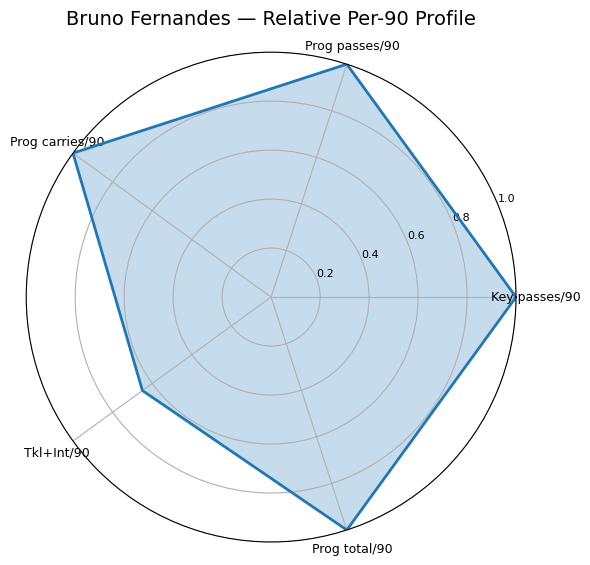

Saved: ../visuals/radar_bruno.png


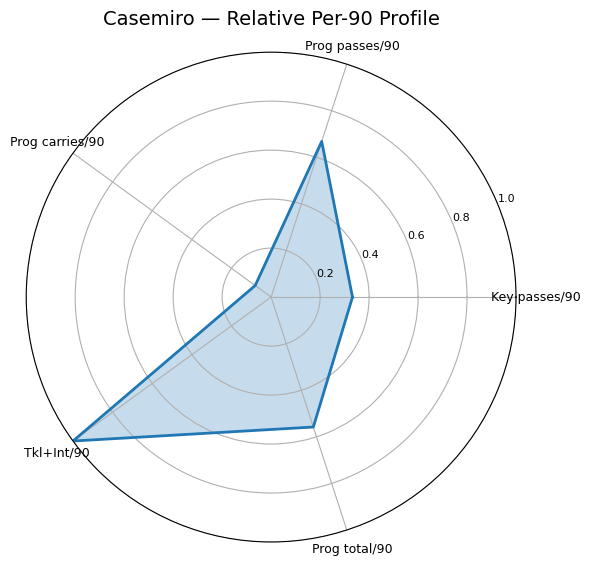

Saved: ../visuals/radar_casemiro.png


In [7]:
radar_plot(
    labels=labels,
    values=bruno_values,
    title="Bruno Fernandes — Relative Per-90 Profile",
    filename="radar_bruno.png",
)

radar_plot(
    labels=labels,
    values=cas_values,
    title="Casemiro — Relative Per-90 Profile",
    filename="radar_casemiro.png",
)


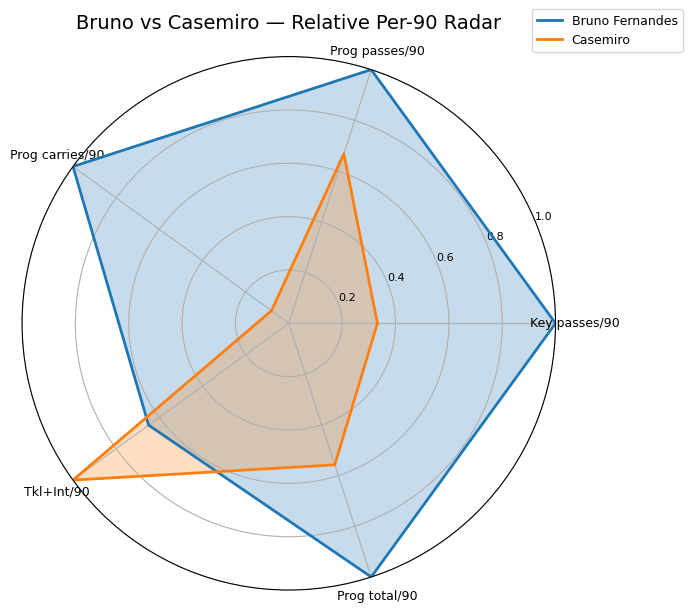

Saved: ../visuals/radar_bruno_casemiro_overlay.png


In [8]:
n = len(labels)
angles = np.linspace(0, 2 * np.pi, n, endpoint=False)

# Close loops
angles_closed = np.concatenate([angles, [angles[0]]])
bruno_closed = np.concatenate([bruno_values, [bruno_values[0]]])
cas_closed   = np.concatenate([cas_values,   [cas_values[0]]])

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": "polar"})

ax.plot(angles_closed, bruno_closed, linewidth=2, label="Bruno Fernandes")
ax.fill(angles_closed, bruno_closed, alpha=0.25)

ax.plot(angles_closed, cas_closed, linewidth=2, label="Casemiro")
ax.fill(angles_closed, cas_closed, alpha=0.25)

ax.set_xticks(angles)
ax.set_xticklabels(labels, fontsize=9)

ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=8)
ax.set_ylim(0, 1.0)

ax.set_title("Bruno vs Casemiro — Relative Per-90 Radar", fontsize=14, pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1), fontsize=9)

fig.tight_layout()
out_path = VIS_DIR / "radar_bruno_casemiro_overlay.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved: {out_path}")


---

## Summary

These radar charts summarise Bruno Fernandes' and Casemiro's per-90
profiles in matches where they start together:

- Bruno tends to dominate creative and progression metrics
  (key passes, progressive passes, progressive carries, xG+xAG).
- Casemiro shows a stronger profile in defensive metrics
  (tackles + interceptions, defensive work rate).
- The overlay radar provides a compact, club-style comparison that can be
  used in reports, presentations, or scouting-style documents.

The radar images saved to `../visuals/` are referenced in the project
README as the main comparative graphic.
